In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.core.pylabtools import figsize
from statsmodels.stats import diagnostic
from scipy import stats
import json
import ast
from pathlib import Path
from collections import Counter
import plotly.express as px
from googleapiclient.discovery import build
import time
from scipy.stats import lognorm, shapiro, probplot, kstest, norm, linregress, stats

from config.ada_config.config import CONFIG

# Data Wrangling

**Step 1: Merging CMU data with TMDB** \
 As the first step, since we observed many missing values in the CMU dataset, we decided to enrich this data using the TMDB dataset. We join the two datasets using their wikidata id. For those which we didn't have the wikidata id we tried to join them based on the title and year of the movies. \
In addition to the missing values, the TMDB dataset also had some information like the budget, voting scores etc which could also help us in our further analysis.

In [69]:
movie_summaries = pd.read_csv(CONFIG["cmu_path"] / 'plot_summaries.csv')
cmu_df = pd.read_csv(CONFIG["cmu_path"] / 'movie_metadata_wikidata.csv')
tmdb_df = pd.read_csv(CONFIG["tmdb_path"] / 'TMDB_movie_dataset_v13.csv') 

/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_62799/2822842373.py:3: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  tmdb_df = pd.read_csv(CONFIG["tmdb_path"] / 'TMDB_movie_dataset_v13.csv')


In [70]:
cmu_df = pd.merge(cmu_df, movie_summaries, on='Wikipedia_movie_ID', how='left')
# percentage of missing values in each column of the cmu dataset
print(f'Percentage of missing values in each column of the CMU dataset \n',cmu_df.isnull().sum() / len(cmu_df) * 100 )

Percentage of missing values in each column of the CMU dataset 
 Wikipedia_movie_ID     0.000000
Freebase_movie_ID      0.000000
movie_name             0.000000
movie_year             7.706659
movie_revenue         89.370919
movie_runtime         23.870069
movie_languages       16.224747
movie_countries        9.200455
movie_genres           2.587628
wikidata_id            0.000000
movie_summary         46.959377
dtype: float64


We observe that around 90% of the movie revenues are missing. In addition, there is also 48% missing in movie_summaries. Overall, we will try to fetch and replace any missing value in the CMU dataset from the TMDB dataset to enrich our data.

For some movies, we can match them with the TMDB movie using their wikidata id, for those which we cannot, we try to do this using the title and year.

In [71]:
cmu_df["cmu_year"] = cmu_df["movie_year"].apply(lambda x: str(x).split('-')[0])
cmu_df["cmu_year"] = cmu_df["cmu_year"].apply(pd.to_numeric, errors='coerce')

tmdb_df['tmdb_year'] = tmdb_df['release_date'].apply(lambda x: str(x).split('-')[0])
tmdb_df['tmdb_year'] = tmdb_df['tmdb_year'].apply(pd.to_numeric, errors='coerce')

In [72]:
tmdb_df_out_nan = tmdb_df[tmdb_df['wikidata_id'].notnull()]
tmdb_only_cmu_df = tmdb_df_out_nan[tmdb_df_out_nan['wikidata_id'].isin(cmu_df['wikidata_id'])]

merged_df = pd.merge(cmu_df, tmdb_only_cmu_df, on='wikidata_id', how='inner')

In [73]:
# merge missing cmu data with tmdb data on title and year
missing_cmu_df = cmu_df[~cmu_df['wikidata_id'].isin(merged_df['wikidata_id'])]

merged_missing_df = pd.merge(missing_cmu_df, tmdb_df, left_on=["movie_name", "cmu_year"], right_on=["title", "tmdb_year"], how='left')
merged_missing_df = merged_missing_df[~merged_missing_df["cmu_year"].isna()]


In [74]:
merged_df = pd.concat([merged_df, merged_missing_df])

In [75]:
def fill_missing_values(origin_df, target_col, source_col):
    filter_mask = origin_df[target_col].isna()
    origin_df.loc[filter_mask,target_col] = origin_df[source_col][filter_mask]
    origin_df.drop(columns=[source_col], inplace=True)

In [76]:
target_fill_col = ['cmu_year', 'movie_revenue', 'runtime', 'movie_countries', 'movie_genres', 'movie_summary', 'wikidata_id', 'wikidata_id']
source_fill_col = ['tmdb_year', 'revenue', 'movie_runtime', 'production_countries', 'genres', 'overview', 'wikidata_id_x', 'wikidata_id_y']

for target, source in zip(target_fill_col, source_fill_col):
    fill_missing_values(merged_df, target, source)

In [77]:
merged_df.rename(columns={'id': 'tmdb_id'}, inplace=True)

In [78]:
merged_df.loc[merged_df['vote_average'] == 0 , 'vote_average']  = None
merged_df.loc[merged_df['vote_count'] == 0 , 'vote_count']  = None
merged_df.loc[merged_df['budget'] == 0 , 'budget']  = None
merged_df.loc[merged_df['popularity'] == 0 , 'popularity']  = None
merged_df.loc[merged_df['movie_revenue'] == 0, 'movie_revenue'] = None
merged_df.loc[merged_df['runtime'] == 0, 'runtime'] = None

merged_df.drop(columns=['spoken_languages', 'production_companies', 'movie_languages', 'status', 'backdrop_path', 'homepage', 'original_title', 'poster_path', 'tagline', 'release_date', 'movie_year', 'title'], inplace=True)

# percentage of missing values in each column of the merged dataset
merged_df.isnull().sum() / len(merged_df) * 100

Wikipedia_movie_ID     0.000000
Freebase_movie_ID      0.000000
movie_name             0.000000
movie_revenue         84.644759
movie_countries        2.712041
movie_genres           1.175477
wikidata_id            0.000000
movie_summary          7.419145
cmu_year               0.076633
tmdb_id                7.078841
vote_average          22.423691
vote_count            22.435381
runtime               10.215612
adult                  7.078841
budget                86.898298
imdb_id                8.424471
original_language      7.078841
popularity             7.402260
keywords              44.595402
dtype: float64

We observe that the percentage of missing values inside the columns reduce. For example the movie summaries missing values reduced from 45% to 8%. Also the movie revenue missing values reduced from 89% to 84% and for movie runtime it reduced from 25% to 8%. 

In [79]:
crew_cast_data = pd.read_csv(CONFIG['tmdb_path'] / 'crew_cast_best.csv')
crew_cast_data.rename(columns={'star_1': 'star_1_popularity',
                       'star_2': 'star_2_popularity',
                       'star_3': 'star_3_popularity',
                       'star_4': 'star_4_popularity',
                       'star_5': 'star_5_popularity',
                       'Director': 'Director_popularity',
                       'Writer': 'Writer_popularity',
                       'Producer': 'Producer_popularity'
                       }, inplace=True)

crew_cast_data = crew_cast_data.groupby(by='movie_id', group_keys=False).apply(lambda group: group.loc[group.isna().sum(axis=1).idxmin()]).reset_index(drop=True)

crew_cast_data['movie_id'].value_counts()

/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_62799/3621072248.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crew_cast_data = crew_cast_data.groupby(by='movie_id', group_keys=False).apply(lambda group: group.loc[group.isna().sum(axis=1).idxmin()]).reset_index(drop=True)


movie_id
2.0          1
202635.0     1
202688.0     1
202681.0     1
202676.0     1
            ..
53579.0      1
53580.0      1
53581.0      1
53582.0      1
1386945.0    1
Name: count, Length: 72452, dtype: int64

In [80]:
merged_df2 = pd.merge(merged_df, crew_cast_data, left_on='tmdb_id', right_on='movie_id',  how='left')
merged_df2.drop(columns='movie_id', inplace=True)
merged_df2['tmdb_id'].value_counts()

tmdb_id
71065.0     2
3056.0      2
449348.0    2
387574.0    2
377063.0    2
           ..
7735.0      1
99800.0     1
201152.0    1
40775.0     1
21549.0     1
Name: count, Length: 71502, dtype: int64

In [81]:
merged_df2_none_tmdb = merged_df2[merged_df2['tmdb_id'].isna()]
merged_df2_tmdb = merged_df2[~merged_df2['tmdb_id'].isna()]
merged_df2_tmdb = merged_df2_tmdb.groupby(by='tmdb_id', group_keys=False).apply(lambda group: group.loc[group.isna().sum(axis=1).idxmin()])

merged_df2 = pd.concat([merged_df2_tmdb, merged_df2_none_tmdb])

/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_62799/691794690.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df2_tmdb = merged_df2_tmdb.groupby(by='tmdb_id', group_keys=False).apply(lambda group: group.loc[group.isna().sum(axis=1).idxmin()])


In [82]:
imdb_data = pd.read_csv(CONFIG['imdb_path'] / 'imdb_movies_data.csv')

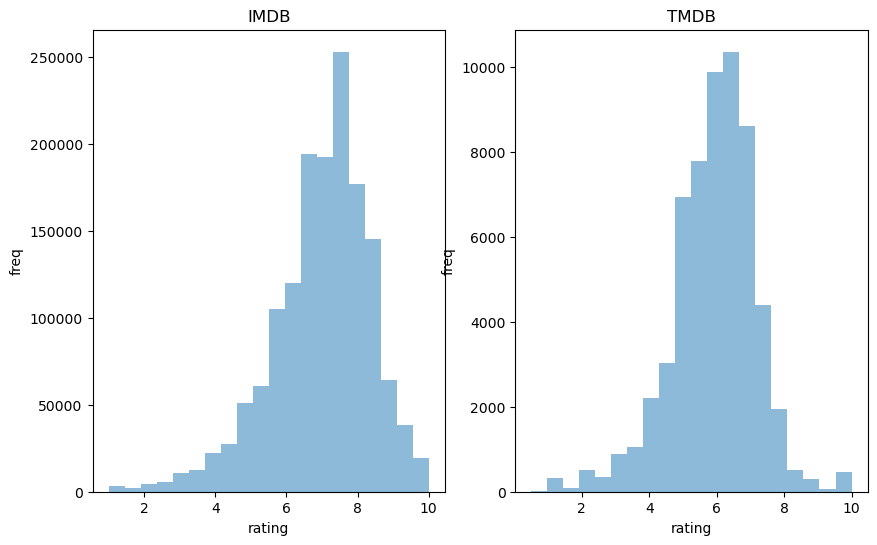

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].hist(imdb_data['averageRating'], bins=20, alpha=0.5)
ax[0].set_xlabel('rating')
ax[0].set_ylabel('freq')
ax[0].set_title('IMDB')

ax[1].hist(merged_df2['vote_average'], bins=20, alpha=0.5)
ax[1].set_xlabel('rating')
ax[1].set_ylabel('freq')
ax[1].set_title('TMDB')

plt.show()

In [84]:
merged_df2 = pd.merge(merged_df2, imdb_data, left_on='imdb_id', right_on='tconst', how='left')

In [85]:
merged_df2.drop(columns=['tconst', 'primaryTitle', 'originalTitle', 'popularity', 'keywords'], inplace=True)
fill_missing_values(merged_df2, 'cmu_year', 'imdb_year')
fill_missing_values(merged_df2, 'movie_genres', 'genres')
fill_missing_values(merged_df2, 'runtime', 'runtimeMinutes')
fill_missing_values(merged_df2, 'averageRating', 'vote_average')
fill_missing_values(merged_df2, 'numVotes', 'vote_count')
fill_missing_values(merged_df2, 'adult', 'isAdult')


merged_df2.rename(columns={'cmu_year': 'year',
                           'averageRating': 'vote_average',
                           'numVotes': 'vote_count'},
                  inplace=True)

**Step 2: Mistakes** \
 We further clean the genres by substituting commonly occuring typos such as "Comdedy" with "Comedy" and similar meaning genres like "Comedy film" and "Comedy". This allows the data on genres to be consistent across datasets.\


In [88]:
merged_df["movie_genres"] = merged_df["movie_genres"].apply(
    lambda x: x.replace("Comdedy", "Comedy") if isinstance(x, str) else x
)


def cleaning_genres(genres):
    """
    Clean the genres by removing "film" from the genre name.
    """
    if isinstance(genres, str):
        genres = genres.split(", ")
        genres = [genre.lower().replace(" film", "") for genre in genres]
        genres = [genre.title() for genre in genres]
        return ", ".join(genres)
    
merged_df["movie_genres"] = merged_df["movie_genres"].apply(cleaning_genres)

In [89]:
merged_df.to_csv( CONFIG["data_path"] / 'enrich_movie_data.csv', index=False)

**Step 3: Merging with Sentiment data** \
 Now we take the generated by LLM sentiment scores and labels for movie plots and merge with the rest of the data, adding `sentiment_score` and `sentiment_label` columns.


In [90]:
sentiment_data = pd.read_csv(CONFIG['data_path'] / 'sentiment_analysis_enriched_final.csv')

def get_sentiment(row):
    if pd.isna(row):
        return [None, None]
    sent = eval(row)
    return [sent['label'], sent['score']]

sentiment_data[['sentiment_label', 'sentiment_score']] = sentiment_data['sentiment'].apply(get_sentiment).apply(pd.Series)
sentiment_data.drop_duplicates(subset='Freebase_movie_ID', inplace=True)

/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_62799/2865912900.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  sentiment_data = pd.read_csv(CONFIG['data_path'] / 'sentiment_analysis_enriched_final.csv')


In [91]:
merged_df2 = pd.merge(merged_df2, sentiment_data[['Freebase_movie_ID', 'sentiment_label', 'sentiment_score']],
                      on='Freebase_movie_ID', how='left')

merged_df2["movie_genres"] = merged_df2["movie_genres"].apply(cleaning_genres)

merged_df2.to_csv(CONFIG["data_path"] / 'enrich_movie_data.csv', index=False)

# Adjusting Budget and Revenue

In our dataset, all the prices are in us-dollars. Different movies are built and displayed in different countries and in different years. Hence, in order to be able to compare monetary features like budget and revenue for different movies, it is important to adjust them. 
1. **Different countries:** Cinema ticket prices and costs can be significantly different in different countries. As a simple example, cinema tickets in Switzerland are around 20CHF but in Italy are 10Euro's. So in order to compare how well a Swiss and Italian movie have been sold, we have to take into account these different prices. The metric used for this purpose is Purchasing Power Parity (PPP) rate. In our research, since there is not sufficient historical PPP rate data, we decided to ignore the country adjustment.
2. **Inflation adjustment** In time, the prices and costs in each country increase due to inflation. For example, a cinema ticket in the 2000's might have cost 5$ but now it costs 10$. So again to compare different movies which have been built in different times, we have to take into account these prices changes. To do this, we adjust all the movies with the US CPI which is an index showing the price level changes in the US. The definition of CPI is as following: \
\
$CPI_t = \frac{\text{Cost of Market Basket in Year } t}{\text{Cost of Market Basket in Base Year}} \times 100$

Using this index, we adjusted movie **revenues** and **budgets** to have a more comparable numbers.

In [92]:
df_movies = pd.read_csv(CONFIG["data_path"] / 'enrich_movie_data.csv')

/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_62799/1769028899.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv(CONFIG["data_path"] / 'enrich_movie_data.csv')


In [93]:
us_cpi = pd.read_csv(CONFIG["data_path"] / 'US CPI.csv')

us_cpi["year"] = us_cpi["Yearmon"].apply(lambda x: float(x.split("-")[-1]))

us_cpi.drop(columns = ["Yearmon"], inplace= True)

In [94]:
previous_years = pd.DataFrame({"year" : np.arange(1850, min(us_cpi["year"]))})

previous_years["CPI"] = us_cpi["CPI"].iloc[0]

us_cpi = pd.concat([previous_years, us_cpi])

In [95]:
us_cpi = us_cpi.groupby("year").aggregate({"CPI": "mean"}).reset_index()

In [96]:
benchmark_cpi = us_cpi[us_cpi["year"] == 2021]["CPI"].iloc[0]
benchmark_cpi

267.20300000000003

In [97]:
def calculate_adjusted_values(row, target_column):
    if pd.isnull(row["year"]):
        return row[target_column]

    filtered_cpi = us_cpi[us_cpi["year"] == row["year"]]
    
    if filtered_cpi.empty:
        print(row)
        return None

    # Otherwise, calculate adjusted revenue
    return row[target_column] * (benchmark_cpi / filtered_cpi["CPI"].iloc[0])

df_movies["adjusted_revenue"] = df_movies.apply(calculate_adjusted_values, args=("movie_revenue",), axis=1)
df_movies["adjusted_budget"] = df_movies.apply(calculate_adjusted_values, args=("budget",), axis = 1)

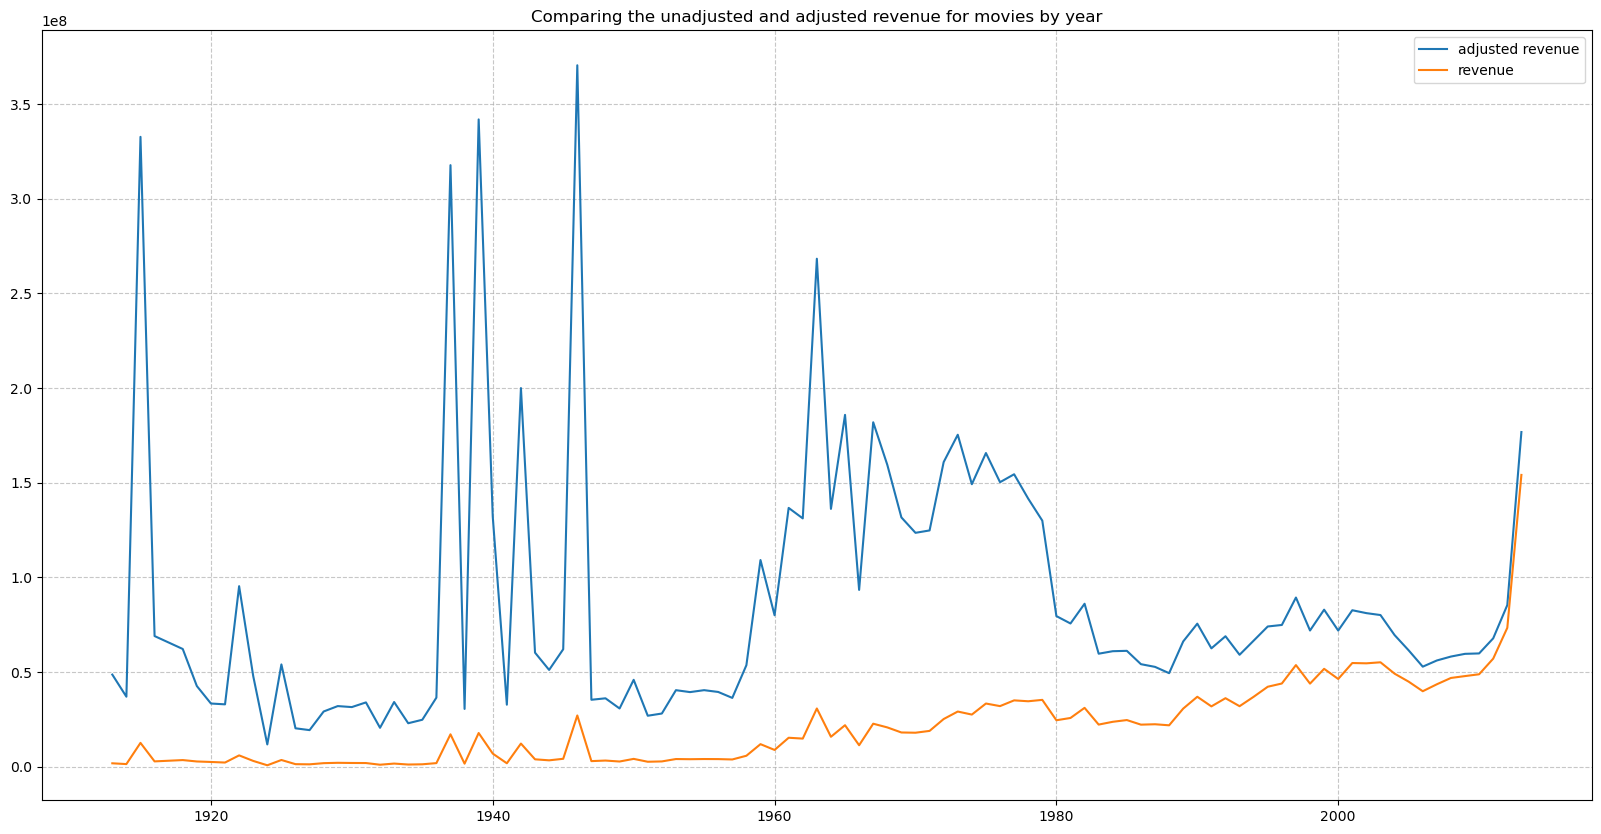

In [98]:
temp_df = df_movies.groupby(["year"])[["movie_revenue", "adjusted_revenue", "budget", "adjusted_budget"]].aggregate("mean").dropna()
temp_df = temp_df.loc[temp_df.index <= 2013]

plt.figure(figsize=(20, 10))
plt.title("Comparing the unadjusted and adjusted revenue for movies by year")
plt.plot(temp_df.index, temp_df["adjusted_revenue"], label = "adjusted revenue")
plt.plot(temp_df.index, temp_df["movie_revenue"], label = "revenue")
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.show()

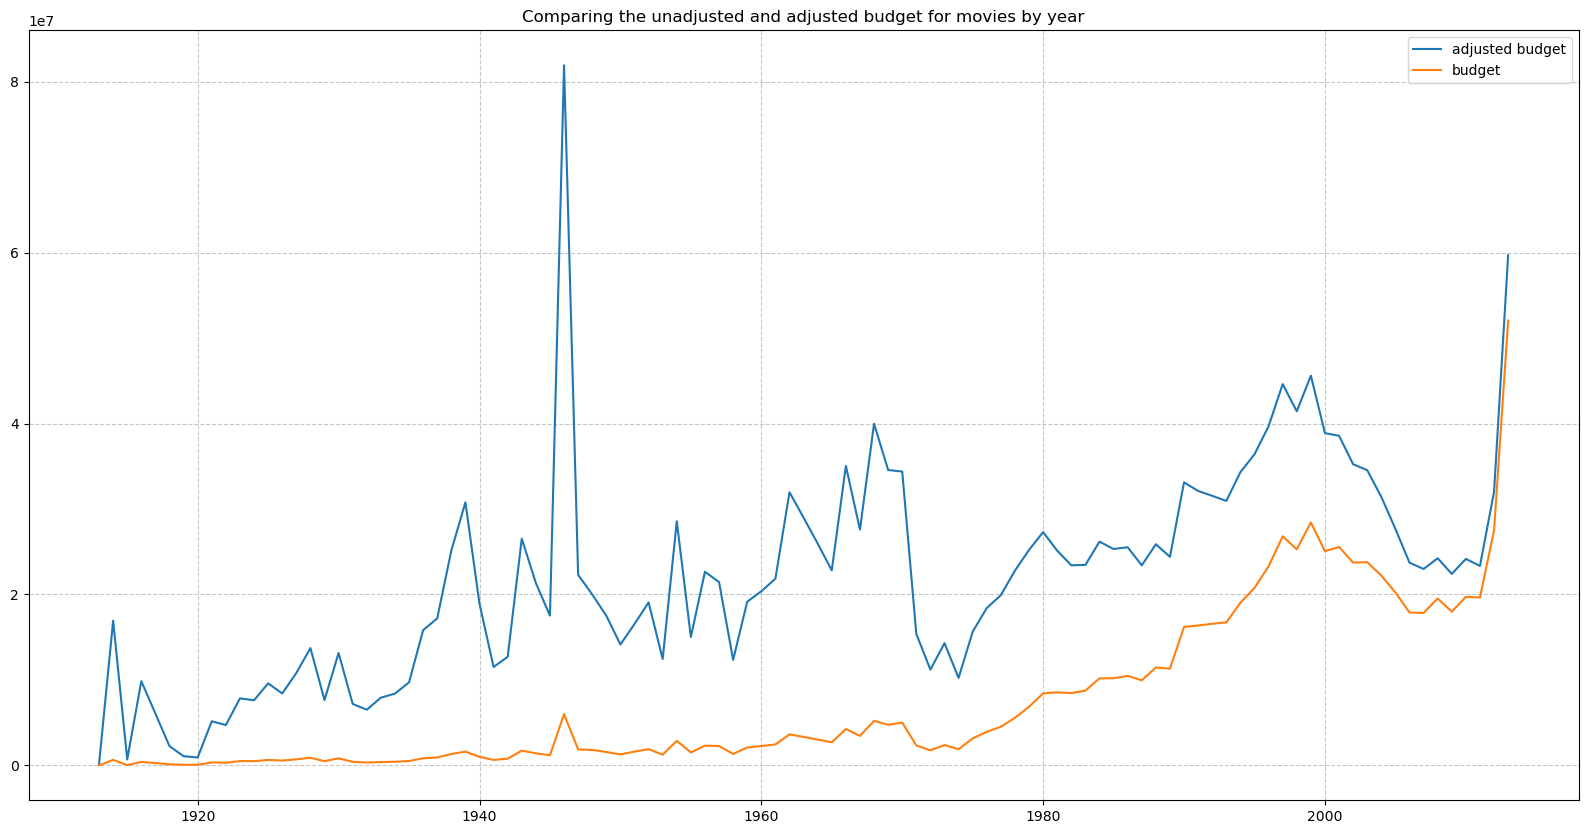

In [99]:
plt.figure(figsize=(20, 10))
plt.title("Comparing the unadjusted and adjusted budget for movies by year")
plt.plot(temp_df.index, temp_df["adjusted_budget"], label = "adjusted budget")
plt.plot(temp_df.index, temp_df["budget"], label = "budget")
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.show()

As we can see in the figure above, when we adjust the prices by inflation, we see that the average revenue for movies in each year does not seem monotonic increasing anymore. We observe that the movies between years 1935 - 1945 and 1960 - 1980 seem to have the highest revenues.

In [100]:
df_movies.to_csv( CONFIG["data_path"] / "MovieVerse.csv", index=False)

# Generate ethnicity data

In [ ]:
# NOTE: uncomment this section to generate ethnicity data
# # Create an empty list to store results
# ethnicity_data = []

# for code in df_chars['ethnicity'].dropna().value_counts().keys():
#     try:
#         response = service.entities().search(ids=code, languages="en").execute()
        
#         if "itemListElement" in response and len(response["itemListElement"]) > 0:
#             entity = response["itemListElement"][0].get("result", {})
#             name = entity.get("name", "N/A")
#             description = entity.get("description", "N/A")
#             detailed_description = entity.get("detailedDescription", {}).get("articleBody", "N/A")
#         else:
#             name = "Not found"
#             description = "Not found"
#             detailed_description = "Not found"

#         ethnicity_data.append({
#             "Freebase Code": code,
#             "Name": name,
#             "Description": description,
#             "Detailed Description": detailed_description
#         })
        
#         print(f"Processed: {code}")

#     except Exception as e:
#         print(f"Error processing {code}: {e}")

#     time.sleep(0.2)

# # Create a DataFrame from the list of dictionaries
# df = pd.DataFrame(ethnicity_data)

# data_folder_ethnicities = '../ADAData/'
# df.to_csv("ethnicity_mappings.csv", index=False)
# print("CSV file 'ethnicity_mappings.csv' created successfully!")